In [1]:
from pathlib import Path
import os

import copy

import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import numpy as np
import pandas as pd


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

### Data set creation, copied from MLP.ipynb

In [2]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("data/")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir  / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")

print(f"Training data dimensions: {df_train_val.shape}")  # (344, 4)
df_train_val.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


In [3]:
X_train_val = []
X_train_val_all = []
y_train_val = []

centers_train_val = []
patients_train_val = []

for sample, label, center, patient in tqdm(
    df_train_val[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks

    # slide-level averaging
    X_train_val.append(np.mean(features, axis=0))
    X_train_val_all.append(features)
    y_train_val.append(label)

    centers_train_val.append(center)
    patients_train_val.append(patient)

# convert to numpy arrays
X_train_val = np.array(X_train_val)
X_train_val_all = np.array(X_train_val_all)
y_train_val = np.array(y_train_val)

centers_train_val = np.array(centers_train_val)
patients_train_val = np.array(patients_train_val)

100%|██████████| 344/344 [00:19<00:00, 17.23it/s]


In [4]:
patients_unique = np.unique(patients_train_val)
y_unique = np.array(
    [np.mean(y_train_val[patients_train_val == p]) for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train_val)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients



In [6]:
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
# split is performed at the patient-level
for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
    # retrieve the indexes of the samples corresponding to the
    # patients in `train_idx_` and `val_idx_`
    train_idx = np.arange(len(X_train_val))[
        pd.Series(patients_train_val).isin(patients_unique[train_idx_])
    ]
    val_idx = np.arange(len(X_train_val))[
        pd.Series(patients_train_val).isin(patients_unique[val_idx_])
    ]
    # set the training and validation folds
    X_train = X_train_val[train_idx]
    X_val = X_train_val[val_idx]

    X_train_all = X_train_val_all[train_idx]
    X_val_all = X_train_val_all[val_idx]

    y_train = y_train_val[train_idx]
    y_val = y_train_val[val_idx]
    break

### Test

In [11]:
X_train_all.shape

(276, 1000, 2048)

In [47]:
X_train_cluster = X_train_all[~y_train.astype(bool)]
X_train_cluster = X_train_cluster.reshape(-1, 2048)

In [48]:
X_train_cluster.shape

(170000, 2048)

In [111]:
def get_wss(data, labels, centroids):
    wss = 0
    for l in np.unique(labels):
        data_l = data[labels == l]
        resid = data_l - centroids[l]
        wss += (resid**2).sum()
    return wss

In [115]:
from sklearn.cluster import KMeans, MiniBatchKMeans

n_clusters = np.arange(2,30)
wss = np.zeros_like(n_clusters)
for k, n_cluster in enumerate(n_clusters):

    kmeans = MiniBatchKMeans(n_clusters=n_cluster, compute_labels=False)
    kmeans.fit(X_train_cluster)
    wss[k] = get_wss(X_train_cluster, kmeans.predict(X_train_cluster), kmeans.cluster_centers_)

C:\Users\Emeric\PycharmProjects\OWKIN_challenge\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Emeric\PycharmProjects\OWKIN_challenge\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Emeric\PycharmProjects\OWKIN_challenge\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Emeric\PycharmProjects\OWKIN_challenge\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` 

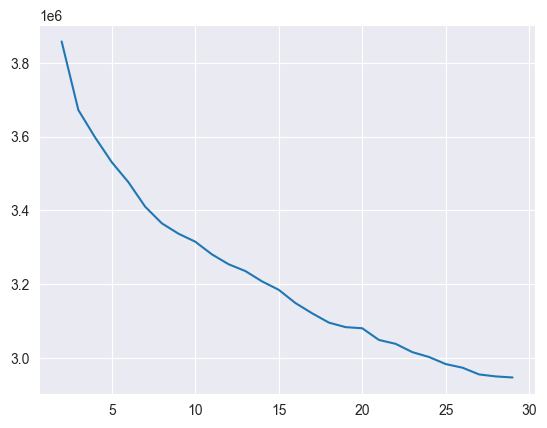

In [116]:
plt.figure()
plt.plot(n_clusters, wss)
plt.show()

In [122]:
n_clusters=8
kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans.fit(X_train_cluster)

C:\Users\Emeric\PycharmProjects\OWKIN_challenge\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans()

In [138]:
X_val_clusters_pos = X_val_all[y_val.astype(bool)].reshape(-1, 2048)
X_val_clusters_neg = X_val_all[~y_val.astype(bool)].reshape(-1, 2048)

dist_pos = np.zeros((X_val_clusters_pos.shape[0], n_clusters))
dist_neg = np.zeros((X_val_clusters_neg.shape[0], n_clusters))

# Avoid memory overflow
size = 1000
n_split = X_val_clusters_pos.shape[0] // size
for k in tqdm(range(n_split)):
    batch = X_val_clusters_pos[k*size: (k+1)*size]
    dist_pos[k * size: (k+1)*size] = np.linalg.norm(batch[:, None] - kmeans.cluster_centers_[None, ...], ord=2, axis=-1)

n_split = X_val_clusters_neg.shape[0] // size
for k in tqdm(range(n_split)):
    batch = X_val_clusters_neg[k*size: (k+1)*size]
    dist_neg[k * size: (k+1)*size] = np.linalg.norm(batch[:, None] - kmeans.cluster_centers_[None, ...], ord=2, axis=-1)

100%|██████████| 46/46 [00:06<00:00,  6.58it/s]


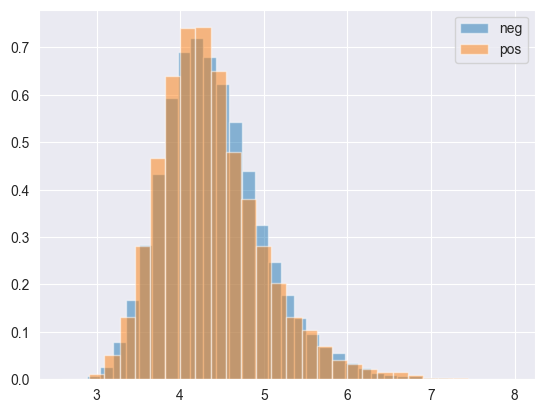

In [140]:
plt.hist(dist_neg.min(axis=-1), density=True, alpha=0.5, bins=int(dist_neg.shape[0] ** (1/3)), label='neg')
plt.hist(dist_pos.min(axis=-1), density=True, alpha=0.5, bins=int(dist_pos.shape[0] ** (1/3)), label='pos')
plt.legend(loc='best')
plt.show()

In [141]:
dist_pos = dist_pos.min(axis=-1).reshape(-1, 1000)
dist_neg = dist_neg.min(axis=-1).reshape(-1, 1000)

extremum_neg = [dist_neg.min(axis=-1), dist_neg.max(axis=-1)]
extremum_pos = [dist_pos.min(axis=-1), dist_pos.max(axis=-1)]

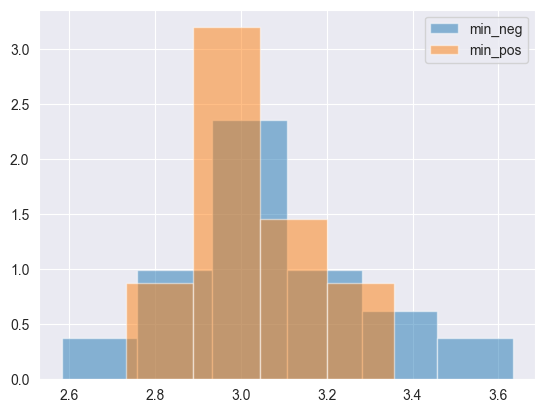

In [146]:
plt.hist(extremum_neg[0], density=True, alpha=0.5, label='min_neg', bins=2 * int(extremum_neg[0].shape[0] ** (1/3)))
plt.hist(extremum_pos[0], density=True, alpha=0.5, label='min_pos', bins=2 * int(extremum_pos[0].shape[0] ** (1/3)))
plt.legend(loc='best')
plt.show()

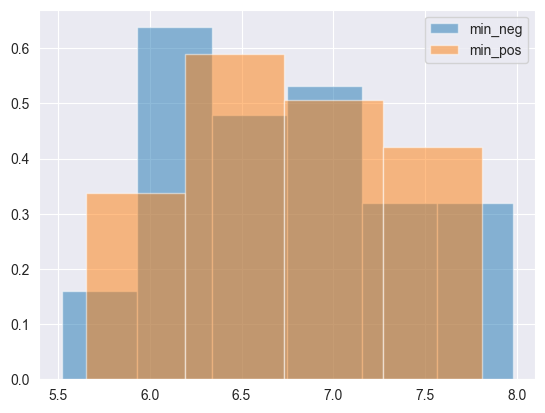

In [145]:
plt.hist(extremum_neg[1], density=True, alpha=0.5, label='min_neg', bins=2 * int(extremum_neg[1].shape[0] ** (1/3)))
plt.hist(extremum_pos[1], density=True, alpha=0.5, label='min_pos', bins=2 * int(extremum_pos[1].shape[0] ** (1/3)))
plt.legend(loc='best')
plt.show()

### Agglomerative clustering

In [144]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=8)
agg.fit(X_train_cluster)

MemoryError: Unable to allocate 2.59 GiB for an array with shape (170000, 2048) and data type float64